#PhlyGreen Tutorial 

Import packages

In [189]:
import sys
sys.path.append('../')
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

Create instances of subsystems. Each one of those requires an Aircraft object as argument. By passing (None) as argument, we are creating empty objects (for the moment).

In [190]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)
climateimpact = pg.ClimateImpact.ClimateImpact(None)

Create instance of Aircraft object.

In [191]:
myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake, climateimpact)

Create the connections with its subsystems.

In [192]:
powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft
climateimpact.aircraft = myaircraft

Define input dictionaries

Constraints ordering:
[0] : cruise,
[1] : take-off,
[2] : climb,
[3] : turn,
[4] : ceiling,
[5] : acceleration,
[6] : landing 

In [193]:
ConstraintsInput = {'speed': np.array([0.4, 140, 170, 210, 0.5, 0.35, 104.]) ,
                    'speedtype': ['Mach','KCAS','KCAS','KCAS','Mach','Mach','KCAS']   ,
                    'beta': np.array([0.95,0.985,0.97, 0.9, 0.8, 0.9, None])   ,
                    'altitude': np.array([8000., 100., 6000., 5000, 9500., 6000, 500.]),
                    'load factor': np.array([1., None, 1., 1.1, 1., 1., None]),
                    'DISA': 0, 
                    'kTO': 1.2,
                    'sTO': 950,
                    'OEI Climb Gradient': 0.021,
                    'Rate of Climb': 5,  #5m/s ~= 1000 ft/min, 7.6 ~= 1500 ft/min
                    'ht': 0.5,
                    'M1': 0.3,
                    'M2': 0.4,
                    'DTAcceleration': 180}

In [194]:
MissionInput = {'Range Mission': 750,  #nautical miles
                'Range Diversion': 220,  #nautical miles
                'Beta start': 0.985,
                'Payload Weight': 4560,  #Kg
                'Crew Weight': 500}  #Kg

In [195]:
MissionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.12, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.06, 'Speed': 110, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.05, 'Speed': 110, 'StartAltitude': 4500, 'EndAltitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.45, 'Altitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 8000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}
# quotacr = 11000
# MissionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.12, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
#                  'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.06, 'Speed': 110, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
#                  'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.05, 'Speed': 110, 'StartAltitude': 4500, 'EndAltitude': quotacr}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
#                  'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.45, 'Altitude': quotacr}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
#                  'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': quotacr, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.06, 'Speed': 110, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.2, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

In [196]:
EnergyInput = {'Ef': 43.5*10**6,
                   'Eta Gas Turbine Model': 'PW127',
                   #'Eta Gas Turbine': 0.22,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive Model': 'constant',
                   'Eta Propulsive': 0.75,
                   'Specific Power Powertrain': [3900,0]  # W/Kg
                   }

In [197]:
AerodynamicsInput = {'NumericalPolar': {'type': 'ATR42'}}

In [198]:
ClimateImpactInput = {'H': 100, 'N':497*50, 'Y':30, 'EINOx_model':'Filippone'}

Import input dictionaries

In [199]:
myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.MissionStages = MissionStages
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput
myaircraft.ClimateImpactInput = ClimateImpactInput

Set aircraft power configuration

In [200]:
myaircraft.Configuration = 'Traditional'

Set inputs

In [201]:
# Initialize Constraint Analysis
myaircraft.constraint.SetInput()

# Initialize Mission profile and Analysis
myaircraft.mission.InitializeProfile()
myaircraft.mission.SetInput()

# Initialize Aerodynamics subsystem
myaircraft.aerodynamics.SetInput()

# Initialize Powertrain
myaircraft.powertrain.SetInput()

# Initialize Weight Estimator
myaircraft.weight.SetInput()

# Initialize Climate Impact Estimator
myaircraft.climateimpact.SetInput()

Either run the Constraint Analysis....

In [202]:
myaircraft.constraint.FindDesignPoint()
print('----------------------------------------')
print('Design W/S: ',myaircraft.DesignWTOoS)
print('Design P/W: ',myaircraft.DesignPW)
print('----------------------------------------')

----------------------------------------
Design W/S:  3328.8528528528527
Design P/W:  168.51352203046332
----------------------------------------


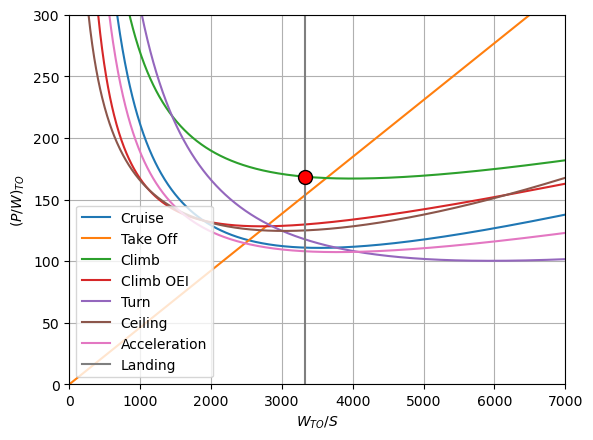

In [203]:
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCruise, label='Cruise')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTakeOff, label='Take Off')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWClimb, label='Climb')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWOEI, label='Climb OEI')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTurn, label='Turn')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCeiling, label='Ceiling')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAcceleration, label='Acceleration')
plt.plot(myaircraft.constraint.WTOoSLanding,myaircraft. constraint.PWLanding, label='Landing')
plt.plot(myaircraft.DesignWTOoS, myaircraft.DesignPW, marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.plot(performance.WTOoSTorenbeek, performance.PWTorenbeek, label='Torenbeek')
plt.ylim([0, 300])
plt.xlim([0, 7000])
plt.legend()
plt.grid(visible=True)
plt.xlabel('$W_{TO}/S$')
plt.ylabel('$(P/W)_{TO}$')
plt.show()

Run Mission analysis to define the aircraft's masses

In [204]:
myaircraft.weight.WeightEstimation()

Wing surface can be readily estimated as S = WTO/(WTO/S)

In [205]:
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * myaircraft.performance.g_acc 

A summary of the preliminary design:

In [206]:
print('----------------------------------------')
print('Fuel mass (trip + altn) [Kg]: ', myaircraft.weight.Wf)
print('Block Fuel mass [Kg]:         ', myaircraft.weight.Wf + myaircraft.weight.final_reserve)
print('Structure [Kg]:               ', myaircraft.weight.WStructure)
print('Powertrain mass [Kg]:         ',myaircraft.weight.WPT)
print('Empty Weight [Kg]:            ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew)
print('Zero Fuel Weight [Kg]:        ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.WPayload)
print('----------------------------------------')
print('Takeoff Weight [Kg]:          ', myaircraft.weight.WTO)
if myaircraft.WellToTankInput is not None:
    print('Source Energy: ', myaircraft.welltowake.SourceEnergy/1.e6,' MJ')
    print('Psi: ', myaircraft.welltowake.Psi)
print('Wing Surface [m^2]:           ', myaircraft.WingSurface)
print('TakeOff shaft peak power [kW]:      ', myaircraft.mission.TO_PP/1000.)
print('Climb/cruise shaft peak power [kW]: ', myaircraft.mission.Max_PEng/1000.)
print('Sizing phase for thermal powertrain: ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PEng > myaircraft.mission.TO_PP else 'Takeoff peak power'  )
print('----------------------------------------')


----------------------------------------
Fuel mass (trip + altn) [Kg]:  2079.890052642449
Block Fuel mass [Kg]:          2209.890052642449
Structure [Kg]:                10311.52982806137
Powertrain mass [Kg]:          1017.7278742578488
Empty Weight [Kg]:             11829.257702319219
Zero Fuel Weight [Kg]:         16389.25770231922
----------------------------------------
Takeoff Weight [Kg]:           18599.181376919856
Wing Surface [m^2]:            54.81106476401199
TakeOff shaft peak power [kW]:       3969.1387096056105
Climb/cruise shaft peak power [kW]:  3303.591592542505
Sizing phase for thermal powertrain:  Takeoff peak power
----------------------------------------


In [207]:
# if myaircraft.ClimateImpactInput is not None:
#     print('Average Temperature Response: [K]: ', myaircraft.climateimpact.ATR())

# IMPIEGA TROPPO TEMPO

In [208]:
times = np.array([])
Ef = np.array([])
beta = np.array([])
for array in mission.integral_solution:
    times = np.concatenate([times, array.t])
    Ef = np.concatenate([Ef, array.y[0]])
    beta = np.concatenate([beta, array.y[1]])

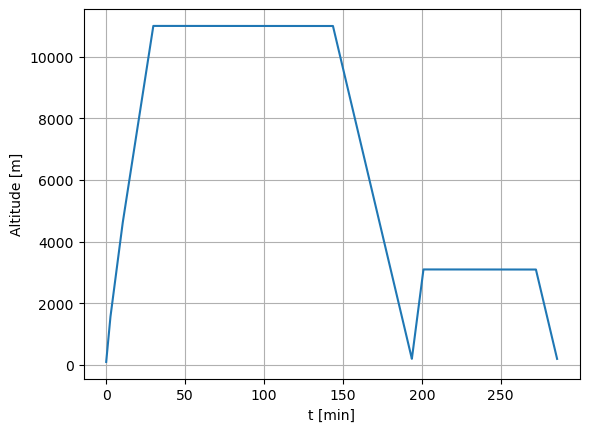

In [209]:
plt.plot(times/60,mission.profile.Altitude(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Altitude [m]')
plt.show()

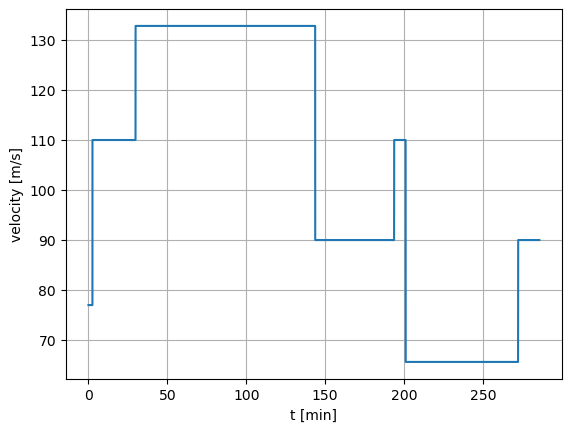

In [210]:
plt.plot(times/60,mission.profile.Velocity(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('velocity [m/s]')
plt.show()

ClimateImpact Test

In [211]:
# alcune distanze in metri 

print('Lunghezze salite e discesa: ',myaircraft.mission.profile.Distances)
print('Lunghezze salita e discesa (diversione): ',myaircraft.mission.profile.DistancesDiversion)
# i due vettori raccolgono le distanze orizzontali percorse durante le varie salite e discese
print('range di missione (diversione esclusa): ',myaircraft.mission.profile.MissionRange)
print('range diversione: ', myaircraft.mission.profile.DiversionRange)
# lunghezza delle crociere [m]:
l_cruise = myaircraft.mission.profile.MissionRange - np.sum(myaircraft.mission.profile.Distances)  
l_dcruise = myaircraft.mission.profile.DiversionRange - np.sum(myaircraft.mission.profile.DistancesDiversion)

TotalRange = myaircraft.mission.profile.MissionRange + myaircraft.mission.profile.DiversionRange

# distanze [m] dal punto di partenza alle quali cominciano le varie fasi di volo
d_2c = myaircraft.mission.profile.Distances[0]  # seconda salita (la prima comincia da 0)
d_3c = d_2c + myaircraft.mission.profile.Distances[1]  # terza salita
d_cruise = d_3c + myaircraft.mission.profile.Distances[2]  # crociera
d_d = d_cruise + l_cruise  # discesa
d_dc = d_d + myaircraft.mission.profile.Distances[3]  # salita (diversione)
d_dcruise = d_dc + myaircraft.mission.profile.DistancesDiversion[0]  # crociera (diversione)
d_dd = d_dcruise + l_dcruise  # discesa (diversione)
d = np.array([0, d_2c, d_3c, d_cruise, d_d, d_dc, d_dcruise, d_dd, TotalRange])
print(d)
qf = np.array([
    myaircraft.MissionStages['Climb1']['input']['StartAltitude'],
    myaircraft.MissionStages['Climb2']['input']['StartAltitude'],
    myaircraft.MissionStages['Climb3']['input']['StartAltitude'],
    myaircraft.MissionStages['Cruise']['input']['Altitude'],
    myaircraft.MissionStages['Descent1']['input']['StartAltitude'],
    myaircraft.DiversionStages['Climb1']['input']['StartAltitude'],
    myaircraft.DiversionStages['Cruise']['input']['Altitude'],
    myaircraft.DiversionStages['Descent1']['input']['StartAltitude'],
    myaircraft.DiversionStages['Descent1']['input']['EndAltitude']
])

print('lunghezze di break tra le fasi: ',qf)    
print('lunghezza crociera: ', l_cruise)
print('lunghezza crociera di diversione: ', l_dcruise)

Lunghezze salite e discesa:  [11704.0, 50050.0, 130020.0, 270000.0]
Lunghezze salita e discesa (diversione):  [48400.0, 72540.0]
range di missione (diversione esclusa):  1368750
range diversione:  401500
[      0.   11704.   61754.  191774. 1098750. 1368750. 1417150. 1697710.
 1770250.]
lunghezze di break tra le fasi:  [  100  1500  4500 11000 11000   200  3100  3100   200]
lunghezza crociera:  906976.0
lunghezza crociera di diversione:  280560.0


In [212]:
if myaircraft.climateimpact.mission_data is None:
    myaircraft.climateimpact.calculate_mission_data()
np.set_printoptions(suppress=True, precision=2)
print(myaircraft.climateimpact.mission_data)

[[   100.   1500.   4500.  11000.    200.    200.   3100.    200.]
 [  1500.   4500.  11000.  11000.  11000.   3100.   3100.   3100.]
 [  1400.   3000.   6500.      0.  10800.   2900.      0.   2900.]
 [ 11704.  50050. 130020. 906976. 270000.  48400. 280560.  72540.]]


In [213]:
if myaircraft.climateimpact.frazioni_di_missione is None:
    myaircraft.climateimpact.calculate_frazioni_di_missione()
np.set_printoptions(suppress=True, precision=6)
print(myaircraft.climateimpact.frazioni_di_missione)
print(sum(myaircraft.climateimpact.frazioni_di_missione[1]))

[[    0.         100.         200.         300.         400.
    500.         600.         700.         800.         900.
   1000.        1100.        1200.        1300.        1400.
   1500.        1600.        1700.        1800.        1900.
   2000.        2100.        2200.        2300.        2400.
   2500.        2600.        2700.        2800.        2900.
   3000.        3100.        3200.        3300.        3400.
   3500.        3600.        3700.        3800.        3900.
   4000.        4100.        4200.        4300.        4400.
   4500.        4600.        4700.        4800.        4900.
   5000.        5100.        5200.        5300.        5400.
   5500.        5600.        5700.        5800.        5900.
   6000.        6100.        6200.        6300.        6400.
   6500.        6600.        6700.        6800.        6900.
   7000.        7100.        7200.        7300.        7400.
   7500.        7600.        7700.        7800.        7900.
   8000.        8100.   

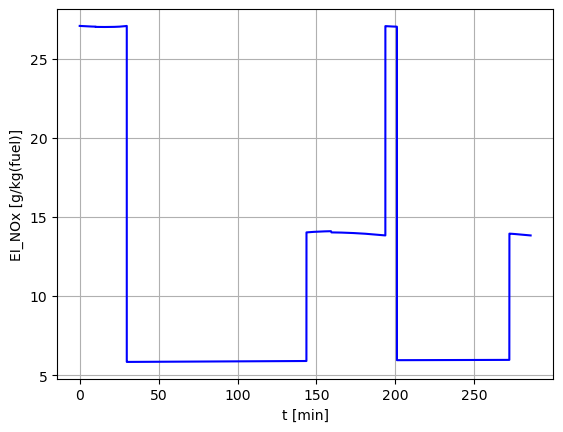

{'co2': 6572.452566350139, 'h2o': 2620.661466329486, 'so4': 0.4159780105284898, 'soot': 0.08319560210569797, 'nox': 25.25021634793529}


In [214]:
myaircraft.climateimpact.calculate_mission_emissions()
print(myaircraft.climateimpact.mission_emissions)

# RENDIMENTO PROPULSIVO COSTANTE (0.75): 2196.6 kg di combustibile (di cui 130 kg di riserva)

# GasTurb:   'nox': 8.693933459601379 kg
# Filippone: 'nox': 22.068569903951268 kg

# Napoli: 24.73 kg per 2260,9 kg di combustibile (quindi la riserva è compresa)


# RENDIMENTO PROPULSIVO PW127 (0.89): 1703.3 kg di combustibile (di cui 130 kg di riserva)

# GasTurb:   'nox': 7.058314130506684 kg
# Filippone: 'nox': 17.07635866054373 kg

In [215]:
print(myaircraft.climateimpact.rf_co2(1))
print(myaircraft.climateimpact.rf_h2o(1))
print(myaircraft.climateimpact.rf_so4(1))
print(myaircraft.climateimpact.rf_soot(1))

2.4172502101994347e-07
1.490833891323742e-07
-2.514418433910723e-07
1.955658781930562e-07


In [216]:
if myaircraft.climateimpact.media_pesata_quote is None:
    myaircraft.climateimpact.calculate_media_pesata_quote()
print(myaircraft.climateimpact.media_pesata_quote)

7736.791696088123


In [217]:
print(myaircraft.climateimpact.rf_ch4(1))

-9.215140292112246e-08


In [218]:
# import cProfile
# cProfile.run('myaircraft.climateimpact.ATR()')

In [219]:
# myaircraft.climateimpact.ATR()  # tempo d'esecuzione: 1m 17.5s
# 5.448190970356856e-06

In [220]:
# years = range(myaircraft.climateimpact.H+1)
# DT = np.zeros(len(years))
# for i in range(len(years)):
#     DT[i] = myaircraft.climateimpact.DeltaT(years[i])
# # valori di epsabs: 1e-4, 1e-8, 1e-7, 1e-4 con scalatura 1e6,  1e-4 con scalatura 1e4
# # tempi: 51.1s, 6m 26.1s, 1m 46.1s, 12m 38.5s, 6m 28.5s
# print(myaircraft.climateimpact.DeltaT(10)) # 7.315064658125778e-07,     uguale,                 uguale,                 7.315064658125779e-07,  uguale a epsabs = 1e-8
# print(myaircraft.climateimpact.DeltaT(30)) # 3.5019683827940256e-06,    uguale,                 uguale,                 uguale,                 uguale a epsabs = 1e-8
# print(myaircraft.climateimpact.DeltaT(70)) # 5.502151031651521e-06,     5.498083889165197e-06,  5.502164865917954e-06   5.4981222866964285e-06, uguale a epsabs = 1e-8

# plt.plot(years, DT)
# plt.grid(visible=True)
# plt.xlabel('t [years]')
# plt.ylabel('DeltaT [K]')
# plt.show()

In [221]:
print(myaircraft.climateimpact.DeltaT(70))  # tempo d'esecuzione: 3s

7.115458235960901e-06


In [222]:
print(myaircraft.climateimpact.DeltaT(10))  # tempo d'esecuzione: 0.2s

1.2749650097201035e-06


[0.000000e+00 3.385914e-07 7.149464e-07 1.128718e-06 1.579788e-06
 2.067040e-06 2.588500e-06 3.141622e-06 3.723522e-06 4.331163e-06
 4.961472e-06 5.272889e-06 5.563276e-06 5.830154e-06 6.071385e-06
 6.285375e-06 6.472297e-06 6.632428e-06 6.766417e-06 6.876859e-06
 6.964259e-06 7.031153e-06 7.078828e-06 7.108709e-06 7.123093e-06
 7.123081e-06 7.110336e-06 7.086843e-06 7.052749e-06 7.009811e-06
 6.959317e-06 6.901621e-06 6.838365e-06 6.769762e-06]


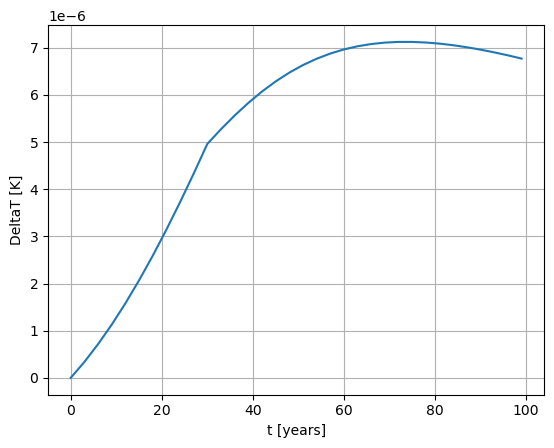

In [223]:
# years = range(0, myaircraft.climateimpact.H+1, 2)  
years = range(0, myaircraft.climateimpact.H+1, 3)  # tempo d'esecuzione: 2m 28s
# years = range(0, myaircraft.climateimpact.H+1, 4)  
DT = np.zeros(len(years))
for i in range(len(years)):
    DT[i] = myaircraft.climateimpact.DeltaT(years[i])
    
np.set_printoptions(precision=6, suppress=False)

plt.plot(years, DT)
plt.grid(visible=True)
plt.xlabel('t [years]')
plt.ylabel('DeltaT [K]')
plt.show()

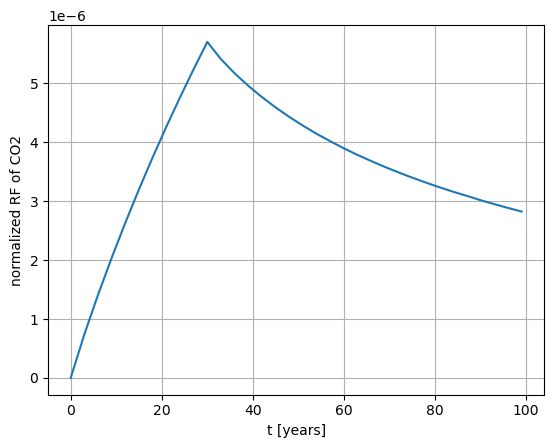

In [73]:
rf_co2 = np.zeros(len(years))
for i in range(len(years)):
    rf_co2[i] = myaircraft.climateimpact.rf_co2(years[i])

plt.plot(years, rf_co2)
plt.grid(visible=True)
plt.xlabel('t [years]')
plt.ylabel('normalized RF of CO2')
plt.show()

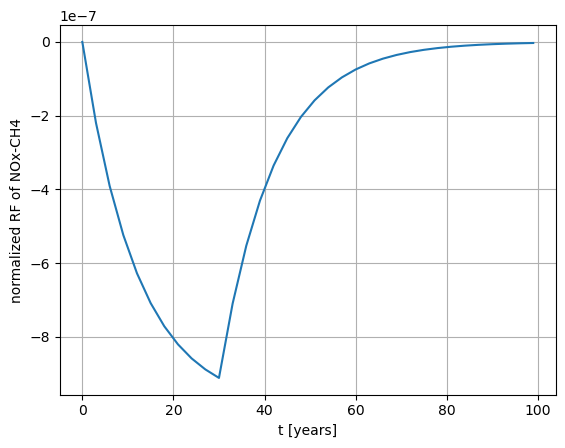

In [74]:
rf_ch4 = np.zeros(len(years))
for i in range(len(years)):
    rf_ch4[i] = myaircraft.climateimpact.rf_ch4(years[i])

plt.plot(years, rf_ch4)
plt.grid(visible=True)
plt.xlabel('t [years]')
plt.ylabel('normalized RF of NOx-CH4')
plt.show()

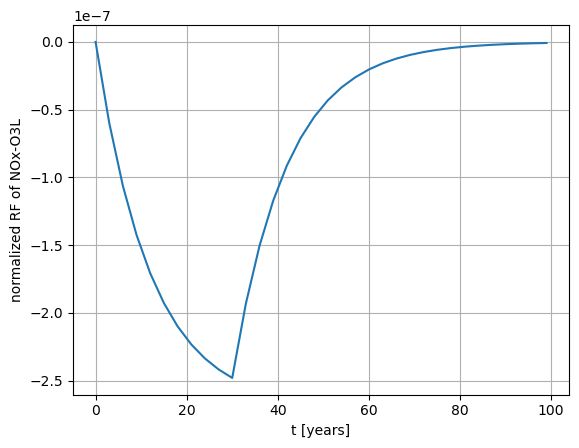

In [75]:
rf_o3l = np.zeros(len(years))
for i in range(len(years)):
    rf_o3l[i] = myaircraft.climateimpact.rf_o3l(years[i])

plt.plot(years, rf_o3l)
plt.grid(visible=True)
plt.xlabel('t [years]')
plt.ylabel('normalized RF of NOx-O3L')
plt.show()

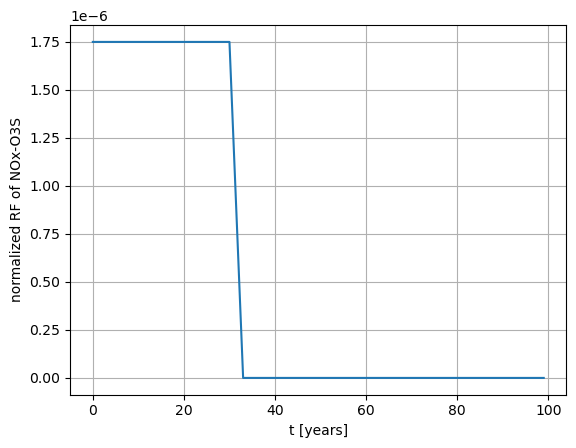

In [76]:
rf_o3s = np.zeros(len(years))
for i in range(len(years)):
    rf_o3s[i] = myaircraft.climateimpact.rf_o3s(years[i])

plt.plot(years, rf_o3s)
plt.grid(visible=True)
plt.xlabel('t [years]')
plt.ylabel('normalized RF of NOx-O3S')
plt.show()

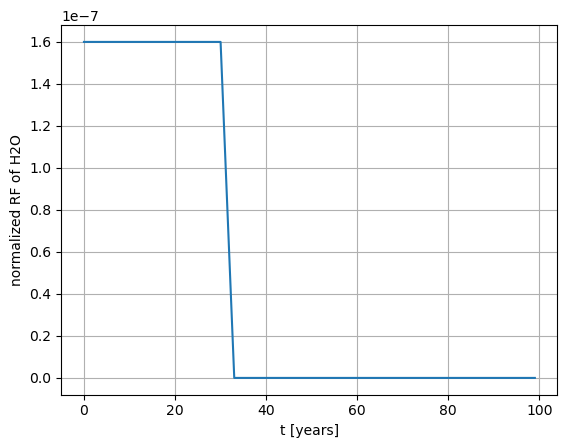

In [77]:
rf_h2o = np.zeros(len(years))
for i in range(len(years)):
    rf_h2o[i] = myaircraft.climateimpact.rf_h2o(years[i])

plt.plot(years, rf_h2o)
plt.grid(visible=True)
plt.xlabel('t [years]')
plt.ylabel('normalized RF of H2O')
plt.show()

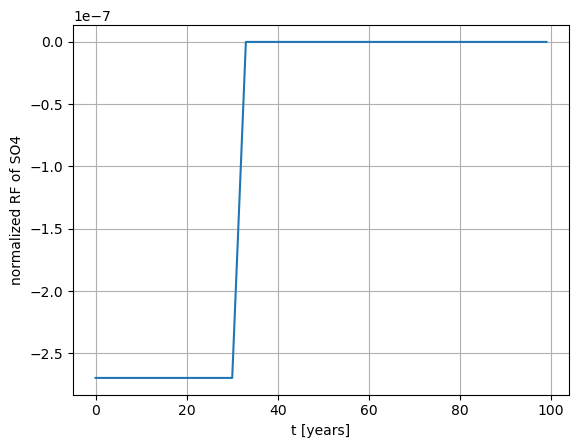

In [78]:
rf_so4 = np.zeros(len(years))
for i in range(len(years)):
    rf_so4[i] = myaircraft.climateimpact.rf_so4(years[i])

plt.plot(years, rf_so4)
plt.grid(visible=True)
plt.xlabel('t [years]')
plt.ylabel('normalized RF of SO4')
plt.show()

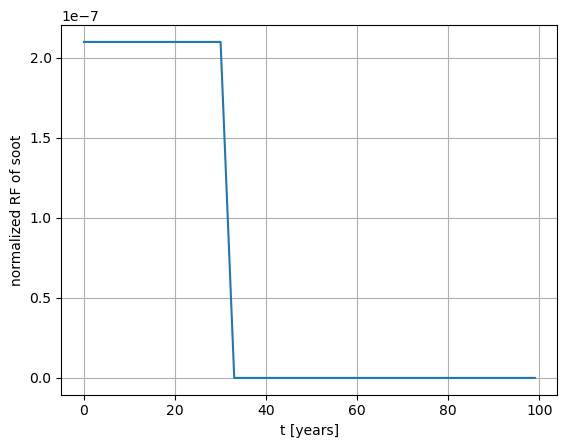

In [79]:
rf_soot = np.zeros(len(years))
for i in range(len(years)):
    rf_soot[i] = myaircraft.climateimpact.rf_soot(years[i])

plt.plot(years, rf_soot)
plt.grid(visible=True)
plt.xlabel('t [years]')
plt.ylabel('normalized RF of soot')
plt.show()

In [80]:
def G_xco2(year):
    alpha = np.array([0.1135, 0.152, 0.0970, 0.041])*10**(-12)  # [ppmv/kg(CO2)]
    tau = np.array([313.8, 79.8, 18.8, 1.7])  # [anni]
    G_xco2 = 0.067e-12  # [ppmv/kg(CO2)]
    for i in range(len(alpha)):
        G_xco2 = G_xco2 + alpha[i]*np.exp(-year/tau[i])
    return G_xco2

def DeltaXCO2(year):
    integrand = lambda k: G_xco2(year - k) * myaircraft.climateimpact.E_co2(k)
    result, _ = integrate.quad(integrand, 0, year, epsabs=1e-4, epsrel=1e-3)
    return result

print(DeltaXCO2(10))

0.0007074167525446728


In [81]:
times = np.array([])
beta = np.array([])
for array in myaircraft.mission.integral_solution:
    times = np.concatenate([times, array.t])
    beta = np.concatenate([beta, array.y[1]])

v0 = myaircraft.mission.profile.Velocity(times)  # [m/s]
alt = myaircraft.mission.profile.Altitude(times)  # [m]
breakpoint_times = np.zeros(5)
alt_cruise = myaircraft.MissionStages['Cruise']['input']['Altitude']
alt_start_diversion = myaircraft.DiversionStages['Climb1']['input']['StartAltitude']
alt_diversion_cruise = myaircraft.DiversionStages['Cruise']['input']['Altitude']
indices_alt_cruise = np.where(alt == alt_cruise)
breakpoint_times[0] = times[indices_alt_cruise[0][0]]
breakpoint_times[1] = times[indices_alt_cruise[0][-1]]
indices_alt_start_diversion = np.where(alt == alt_start_diversion)
for index in indices_alt_start_diversion[0]:
    if times[index] > breakpoint_times[1]:
        breakpoint_times[2] = times[index]
        break
indices_alt_diversion_cruise = np.where(alt == alt_diversion_cruise)
for index in indices_alt_diversion_cruise[0]:
    if times[index] > breakpoint_times[2]:
        breakpoint_times[3] = times[index]
        break
breakpoint_times[4] = times[indices_alt_diversion_cruise[0][-1]]

print(breakpoint_times/60)

[ 14.666667 147.166667 174.033333 181.366667 252.616667]


In [82]:
# andamento di EI_NOx durante la missione

times = np.array([])
beta = np.array([])
for array in myaircraft.mission.integral_solution:
    times = np.concatenate([times, array.t])
    beta = np.concatenate([beta, array.y[1]])

v0 = myaircraft.mission.profile.Velocity(times)  # [m/s]
alt = myaircraft.mission.profile.Altitude(times)  # [m]

portata = np.zeros(len(times))  # [kg(fuel)/s]
coeff = np.array([
    [0.7194e+1, 0.5609e+0, -0.1059e-1, -0.3223e+1, 0.2889e+0, 0.2591e+0],
    [0.1605e+0, 0.2412e+0, -0.1650e-2, -0.8818e+1, 0.3714e+2, -0.2268e+0],
    [ 0.3699e+0, 0.5470e+0, -0.7445e-2, -0.6914e+1, 0.6782e+1, 0.1138e+0]
])
# coeff sono i coefficienti del metodo di Filippone per climbout, idle e approach

EI_NOx = np.zeros(len(times))  # [g/kg(fuel)]
dNOx = np.zeros(len(times))  # [g/s]
EI_co2 = 3.16e3 # [g/kg]
dCO2 =  np.zeros(len(times))  # [g/s]
EI_h2o = 1.26e3 # [g/kg]
dH2O = np.zeros(len(times))  # [g/s]
EI_so4 = 2e-1 # [g/kg]
dSO4 = np.zeros(len(times))  # [g/s]
EI_soot = 4e-2 # [kg/kg]
dSoot = np.zeros(len(times))  # [g/s]


OPR = 15.77
                
for t in range(len(times)):
    power = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt[t],myaircraft.mission.DISA,v0[t],'TAS')
    PRatio = myaircraft.powertrain.Traditional(alt[t],v0[t],power)
    portata[t] = power * PRatio[0]/myaircraft.weight.ef

    if times[t] <= breakpoint_times[0] or (times[t] <= breakpoint_times[3] and times[t] >= breakpoint_times[2]):
        c = coeff[0]
    elif (times[t] > breakpoint_times[0] and times[t] < breakpoint_times[1]) or (times[t] > breakpoint_times[3] and times[t] < breakpoint_times[4]):
        c = coeff[1]
    else:
        c = coeff[2]

    mfuel = 0.5*portata[t]  # portata di combustibile del singolo motore
                        
    EI_NOx[t] =  2*(c[0] + c[1]*OPR + c[2]*(OPR)**2 + c[3]*mfuel + c[4]*(mfuel)**2 + c[5]*OPR*mfuel)
    dNOx[t] = EI_NOx[t]*portata[t]
    dCO2[t] = EI_co2*portata[t]
    dH2O[t] = EI_h2o*portata[t]
    dSO4[t] = EI_so4*portata[t]
    dSoot[t] = EI_soot*portata[t]


In [83]:
# # grafici delle emissioni durante la missione

# plt.figure(1)
# plt.plot(times/60,portata, 'b')
# plt.grid(visible=True)
# plt.xlabel('t [min]')
# plt.ylabel('Portata di combustibile [kg/s]')
# plt.show()

# plt.figure(2)
# plt.plot(times/60, dCO2, 'r', label='CO2')  
# plt.plot(times/60, dH2O, 'g', label='H2O')  
# plt.plot(times/60, dNOx, 'b', label='NOx')  
# plt.plot(times/60, dSO4, 'm', label='SO4') 
# plt.plot(times/60, dSoot, 'k', label='soot') 
# plt.yscale('log')
# plt.grid(visible=True)
# plt.xlabel('t [min]')
# plt.ylabel('Emissioni per unità di tempo [g/s]')
# plt.legend(loc='center', bbox_to_anchor=(1.1, 0.8))
# plt.show()